# Generate CAMs for vanilla convnets and convents with deconv layers

Two VGG-like convnets were trained on the [simpsons dataset](https://www.kaggle.com/alexattia/the-simpsons-characters-dataset/version/2) from Kaggle. They were trained as regular old classification networks on images of 20 characters. After training they are run on the image below of the whole simpsons family and the class activation map for Homer will be applied. 

In [1]:
import os
import glob
import scipy
import random
import numpy as np
import pandas as pd

from skimage.io import imshow
from PIL import Image

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from utils import make_dot

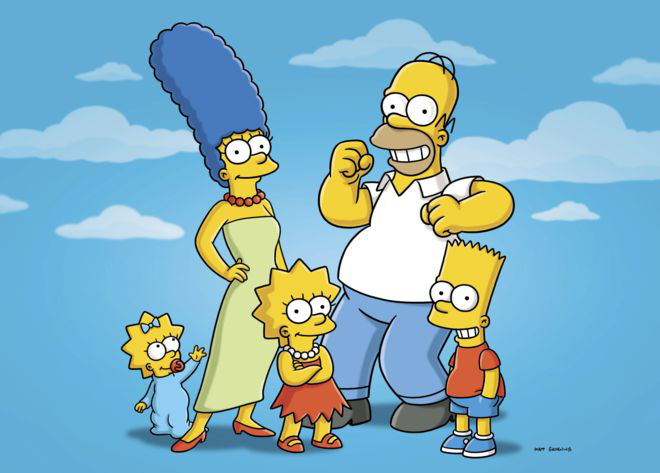

In [2]:
img= Image.open('../plots/homer.jpg')
img

## Load the trained vanilla model and generate output from image

Load it up, then set it up to get output from last conv layer.

{139759221596488: 'classifier.0.weight', 139759221596616: 'classifier.0.bias', 139759221588488: 'features.24.weight', 139759221562952: 'features.14.weight', 139759221588616: 'features.24.bias', 139759221514952: 'features.0.weight', 139759221589704: 'features.26.bias', 139759221515080: 'features.0.bias', 139759221590920: 'features.28.weight', 139759221562056: 'features.12.bias', 139759221570568: 'features.21.weight', 139759221568584: 'features.17.weight', 139759221570696: 'features.21.bias', 139759221568712: 'features.17.bias', 139759221591048: 'features.28.bias', 139759221517384: 'features.5.weight', 139759221589576: 'features.26.weight', 139759221560904: 'features.10.weight', 139759221515912: 'features.2.weight', 139759221561032: 'features.10.bias', 139759221516040: 'features.2.bias', 139759221569672: 'features.19.bias', 139759221563080: 'features.14.bias', 139759221569544: 'features.19.weight', 139759221517512: 'features.5.bias', 139759221559432: 'features.7.weight', 139759221559560:

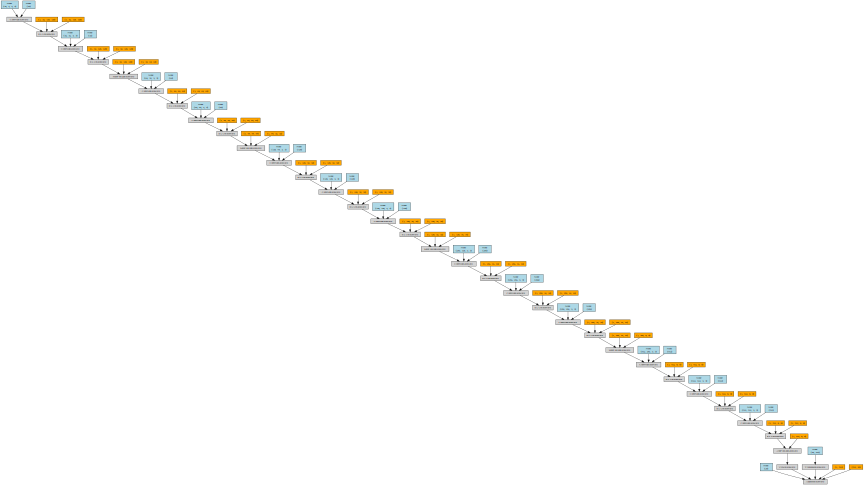

In [3]:
from models import VGGlike_vanilla, VGGlike_upsample
net = VGGlike_vanilla()
net.load_state_dict(torch.load('../models/best_{}_{}_classifier.pth'.format('vgglike', 'vanilla')))

inputs = torch.randn(1, 3, 128, 128)
y = net(Variable(inputs))
g = make_dot(y, net.state_dict())
g

In [4]:
conv_out = nn.Sequential(*list(net.features.children()))

In [5]:
# get the weights for the softmax
net_params = list(net.parameters())
softmax_weights = net_params[-2].data.numpy()

Create torch functions to prep image for the network.

In [6]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])

torchify_img = transforms.Compose([transforms.Scale(128), transforms.CenterCrop(128), 
                                   transforms.ToTensor(), normalize])

plotify_img = transforms.Compose([transforms.Scale(128), transforms.CenterCrop(128)])

torch_img = torchify_img(img)
plt_img = plotify_img(img)
torch_img.size()

torch.Size([3, 128, 128])

Get output from the network.

In [7]:
conv_out.eval()
conv_maps = conv_out(Variable(torch_img).unsqueeze(0))
conv_maps_np = conv_maps.squeeze().data.numpy()
conv_maps_np.shape

(512, 8, 8)

### Generate the CAM

Figure out where homer is in the indexes that pytorch set up for us and then create the CAM for his index.

In [8]:
# figure out where homer is in softmax
homer_idx = datasets.ImageFolder('../data/').classes.index('homer_simpson')

# write function to get the CAM
def getCAM(conv_feats, softmax_weights, class_idx):
    '''Tweaked code from the CAM authors github repo'''
    c, h, w = conv_feats.shape
    
    cam = softmax_weights[class_idx].dot(conv_feats.reshape((c, h*w)))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    cam_img = np.uint8(255 * cam_img)
    
    return cam_img

Display the CAM.

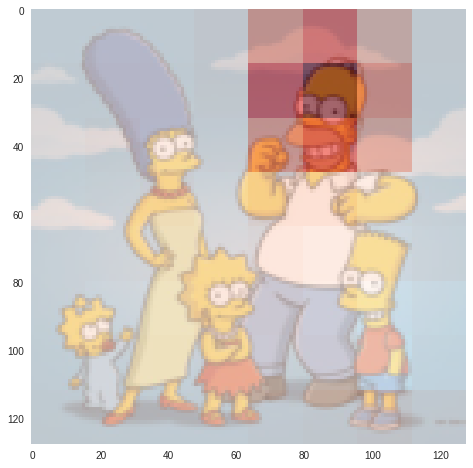

In [9]:
cam = getCAM(conv_maps_np, softmax_weights, homer_idx)

plt.figure(figsize=(8,8))
plt.grid(visible=False)
plt.imshow(plt_img)
plt.imshow(scipy.misc.imresize(cam, (128,128), interp='nearest'), 
           alpha=0.6, cmap='Reds')
plt.show()

{139759221576008: 'conv1.bias', 139759176384840: 'conv13.bias', 139759176339848: 'lastdeconv.0.weight', 139759221576136: 'conv3.weight', 139759221576200: 'conv3.bias', 139759177192776: 'conv10.bias', 139759176408904: 'conv12.bias', 139759177194120: 'conv11.bias', 139759221576520: 'conv4.bias', 139759177038728: 'conv7.weight', 139759177137160: 'conv5.weight', 139759176388488: 'deconv1.bias', 139759177194696: 'conv10.weight', 139759221577992: 'conv2.bias', 139759177147848: 'conv6.weight', 139759176330568: 'dense.bias', 139759177178568: 'conv9.weight', 139759176407880: 'conv12.weight', 139759177178760: 'conv9.bias', 139759176406280: 'conv13.weight', 139759176331016: 'dense.weight', 139759177148232: 'conv6.bias', 139759221472648: 'conv5.bias', 139759221577608: 'conv1.weight', 139759221577672: 'conv4.weight', 139759176387208: 'deconv1.weight', 139759177037832: 'conv7.bias', 139759176339592: 'lastdeconv.0.bias', 139759177193544: 'conv11.weight', 139760311158920: 'conv8.weight', 1397591771772

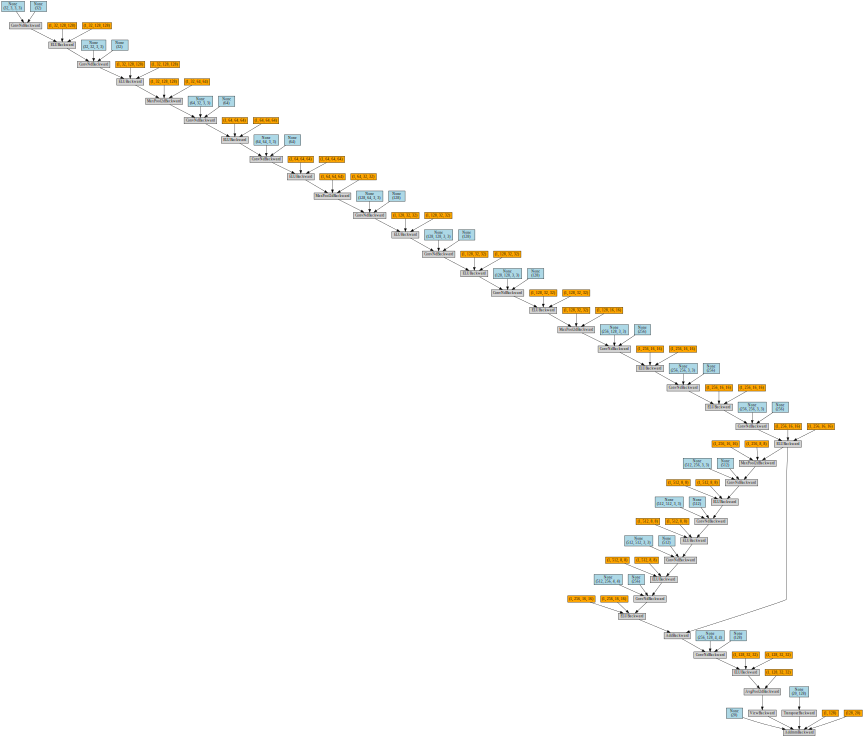

In [10]:
net = VGGlike_upsample()

inputs = torch.randn(1, 3, 128, 128)
y = net(Variable(inputs))
g = make_dot(y, net.state_dict())
g


In [11]:

# get softmax for the upsample net
net_params = list(net.parameters())
softmax_weights = net_params[-2].data.numpy()

# make a function to extract last conv layer
net.load_state_dict(torch.load('../models/best_{}_{}_classifier.pth'.format('vgglike', 'upsample')))
net.eval()

# have to use the pytorch hooks feature since this net wasn't made with sequentials
conv_maps = []
def get_last_conv(self, input, output):
    conv_maps.append(output.data.squeeze().numpy())

# tell net where we want to get conv maps from
net._modules.get('lastdeconv').register_forward_hook(get_last_conv)

# push image through to populate conv_maps list
_ = net(Variable(torch_img).unsqueeze(0))

Display the CAM.

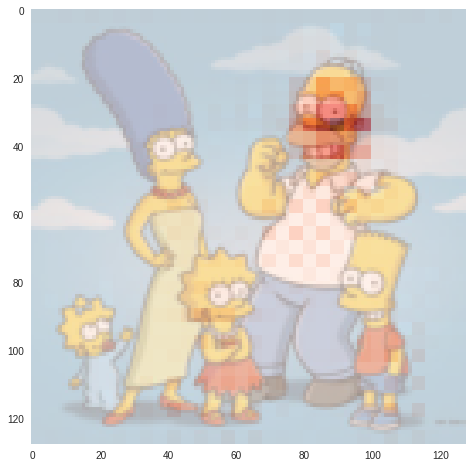

In [12]:
cam = getCAM(conv_maps[0], softmax_weights, homer_idx)

plt.figure(figsize=(8,8))
plt.grid(visible=False)
plt.imshow(plt_img)
plt.imshow(scipy.misc.imresize(cam, (128,128), interp='nearest'), 
           alpha=0.6, cmap='Reds')
plt.show()

## Plot training curves

In [13]:
import seaborn as sns

def plot_curves(log_file, title):
    dat = pd.read_csv(log_file, header=None)
    dat.columns = ['Epoch', 'Train Loss', 'Valid Loss', 'Valid Acc']
    
    train_loss = dat['Train Loss'].values
    valid_loss = dat['Valid Loss'].values
    valid_acc = dat['Valid Acc'].values
    
    plt.title(title, fontsize=24)
    plt.plot(train_loss, linewidth=1, label='Train loss')
    plt.legend(loc=2)

    plt.plot(valid_loss, linewidth=1, label='Valid loss')
    plt.legend(loc=2)
    #pyplot.ylim([0,0.85])
    plt.twinx()
    plt.plot(valid_acc, linewidth=1, label='Valid accuracy', color='r')
    plt.grid()
    plt.legend(loc=3)
    plt.show()

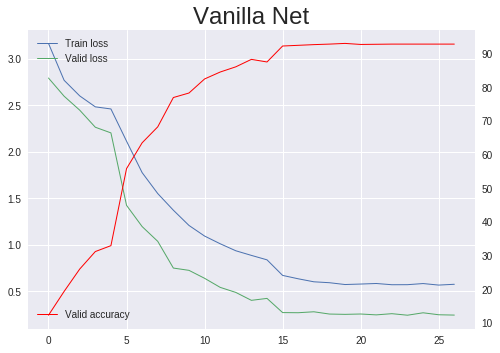

In [14]:
plot_curves('../logs/losses_vgglike_vanilla.txt', 'Vanilla Net')

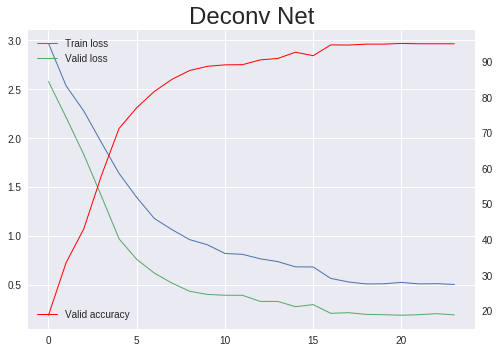

In [15]:
plot_curves('../logs/losses_vgglike_upsample.txt', 'Deconv Net')